# Milestone M1d - MR simulator and fitting

In [1]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# set environment variable
if IN_COLAB:
    print("Installing DeepMR in COLAB")
    !pip uninstall matplotlib
    !pip install git+https://github.com/INFN-PREDATOR/deep-mr.git
else:
    print("Skipping installation")

Skipping installation


The fourth and final deliverable for the **PREDATOR** project Milestone M1 was to develop an efficient Bloch simulator for the generation of synthetic MR data and quantitative parameter fitting. Currently, the [DeepMR](https://github.com/INFN-PREDATOR/deep-mr) framework includes a numerical simulator based on the Extended Phase Graphs formalism. Supported MR sequences include MPRAGE, Multiecho MPRAGE (ME-MPRAGE), Fast Spin Echo (FSE) and T1-T2 Shuffling and balanced / unbalanced MR Fingerprinting

DeepMR also contains helper classes to define custom signal models. These helper classes abstract away the boilerplate code required to enable massive parallelization on CPU and GPU and the computation of signal derivatives, allowing the user to focus only on the description of the spin dynamics for a specific sequence.

Here, we show an example of MR signal simulation for two representative sequences, namely 1) MPnRAGE (an inversion-prepared Fast Gradient Echo sequence for multicontrast T1-weighted imaging) and 2) T2 Shuffling (a Fast Spin Echo sequence for multicontrast T2-weighted imaging). Finally, we will show an example of T1 and T2 fitting based on these numerical simulation to retrieve tissue properties from the contrast-weighted images. 

In [2]:
%matplotlib inline
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt # for displaying the results

import deepmr

def simulate(simulator, tau, nshots, flip=90.0):
    """
    Generate MR signals from a numerical Shepp-Logan phantom.

    Parameters
    ----------
    simulator : str
        Type of simulator; can be either "mpnrage" or "t2shuffle".
    tau : float
        Time resolution of the single image volume in [ms].
    nshots : int
        Number of volumes in the acquisition.
    flip : float
        Excitation / Refocusing flip angle in [deg].

    Returns
    -------
    signal : torch.Tensor
        simulated image of shape (ncontrasts, ny, nx)

    """
    # generate phantom
    props = deepmr.shepp_logan(128, nslices=1, qmr=True)
    flip = flip * torch.ones(nshots, dtype=torch.float32)

    # generate signals
    if simulator == "mpnrage":
        sig = deepmr.bloch.mprage(nshots, flip, tau, props["T1"].flatten(), props["T2"].flatten(), asnumpy=False, TI=1.0)
    elif simulator == "t2shuffle":
        phases = 0.0 * flip
        sig = deepmr.bloch.fse(flip, phases, tau, props["T1"].flatten(), props["T2"].flatten(), asnumpy=False)
    else:
        raise ValueError(f"Simulator type = {simulator} not recognized; must be either 'mpnrage' or 't2shuffle'")

    # reshape
    sig = props["M0"] * (sig.T).reshape(-1, *props["M0"].shape)
    return sig, props
    

## MR simulation

First, we perform the simulation. The object is a numerical Shepp-Logan phantom, consisting of a set of three quantitative properties maps (Proton Density, longitudinal relaxation time constant T1 and transverse relaxation time constant T2). We use the following parameters:

* **MPnRAGE**: flip angle = 10°, TR=10 ms, number of inversion volumes: 1000
* **T2Shuffling**: refocusing angle = 90°, ETL=64, Echo Spacing: 10 ms

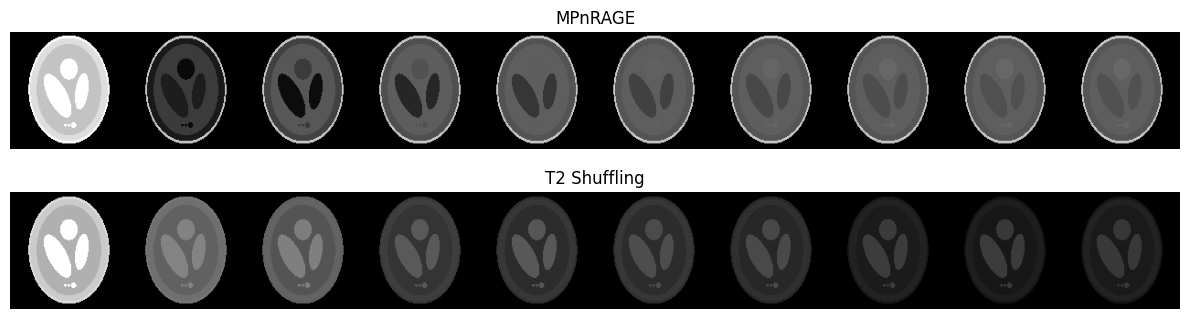

In [3]:
# simulate MPnRAGE and keep ground truth maps ('props')
sig_mpnrage, props = simulate("mpnrage", tau=10.0, nshots=1000, flip=10.0)

# simulate T2-Shuffling
sig_t2shuffle, _ = simulate("t2shuffle", tau=10.0, nshots=64)

# plot
plt.rcParams['figure.figsize'] = [12, 3.5]

plt.subplot(2, 1, 1)
img_mpnrage = [sig_mpnrage[n] for n in range(0, sig_mpnrage.shape[0], 100)]
_ = plt.imshow(abs(torch.cat(img_mpnrage, axis=-1)), cmap="gray"), plt.axis("off"), plt.title("MPnRAGE")
plt.subplot(2, 1, 2)
img_t2shuffle = [sig_t2shuffle[n] for n in range(0, 10)]
_ = plt.imshow(abs(torch.cat(img_t2shuffle, axis=-1)), cmap="gray"), plt.axis("off"), plt.title("T2 Shuffling")
plt.tight_layout()

MPnRAGE signal evolution clearly shows the zero-crossing of the signal during the longitudinal magnetization recovery from -M0 to +M0. Similarly, signal in T2-Shuffling exhibitsa clear exponential T2 decay.

## Parameter fitting

We now use a general purpose template matching routine included in `deepmr.recon` to retrieve T1 from MPnRAGE signal and T2 from T2Shuffling.

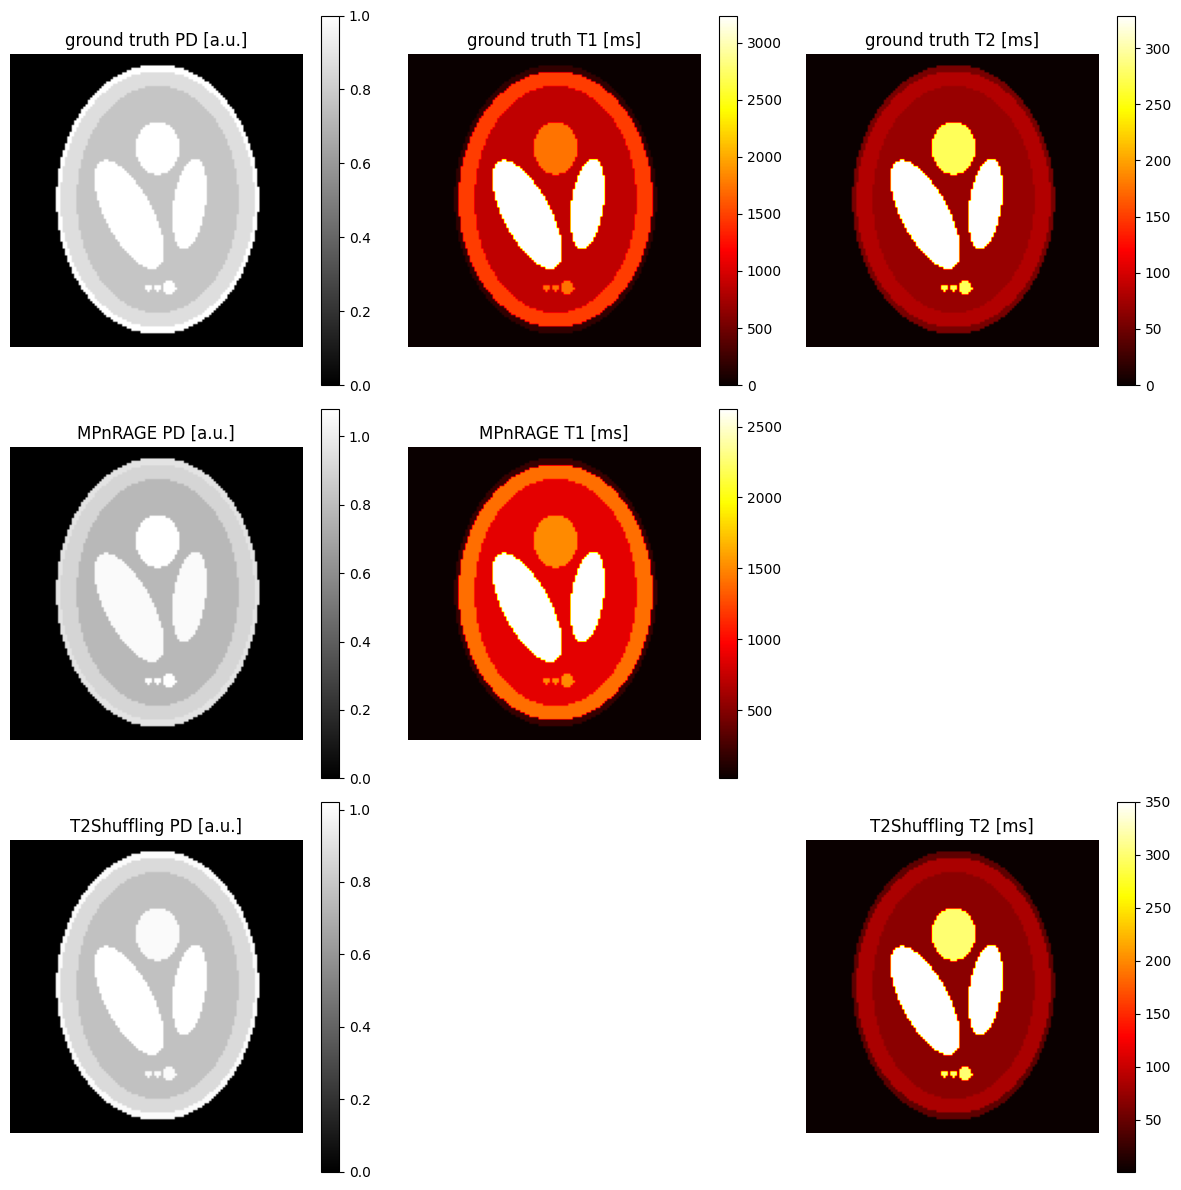

In [4]:
# fit T1
m0_mpnrage, t1map = deepmr.recon.mpnrage_fit(sig_mpnrage.clone(), (20.0, 3000.0, 3500), flip=10.0, TR=10.0, TI=1.0)

# fit T2
ETL = sig_t2shuffle.shape[0]
m0_t2shuffle, t2map = deepmr.recon.fse_fit(sig_t2shuffle.clone(), (1.0, 350.0, 1000), flip=90.0 * np.ones(ETL), ESP=10.0)

# plotting
plt.rcParams['figure.figsize'] = [12, 12]

plt.subplot(3, 3, 1)
_ = plt.imshow(props["M0"], cmap="gray"), plt.colorbar(), plt.axis("off"), plt.title("ground truth PD [a.u.]")
plt.subplot(3, 3, 2)
_ = plt.imshow(props["T1"], cmap="hot"), plt.colorbar(), plt.axis("off"), plt.title("ground truth T1 [ms]")
plt.subplot(3, 3, 3)
_ = plt.imshow(props["T2"], cmap="hot"), plt.colorbar(), plt.axis("off"), plt.title("ground truth T2 [ms]")

plt.subplot(3, 3, 4)
_ = plt.imshow(abs(m0_mpnrage), cmap="gray"), plt.colorbar(), plt.axis("off"), plt.title("MPnRAGE PD [a.u.]")
plt.subplot(3, 3, 5)
_ = plt.imshow(t1map, cmap="hot"), plt.colorbar(), plt.axis("off"), plt.title("MPnRAGE T1 [ms]")

plt.subplot(3, 3, 7)
_ = plt.imshow(abs(m0_t2shuffle), cmap="gray"), plt.colorbar(), plt.axis("off"), plt.title("T2Shuffling PD [a.u.]")
plt.subplot(3, 3, 9)
_ = plt.imshow(t2map, cmap="hot"), plt.colorbar(), plt.axis("off"), plt.title("T2Shuffling T2 [ms]")

plt.tight_layout()

We were able to retrieve the underlying tissue properties!